# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`.

In [2]:
import os
driver_folder ="/content/drive/MyDrive/Elbrus_Moon_phase2_okt_2024/week8"
os.chdir(driver_folder)

In [3]:
!pip -qq install torchutils

In [4]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [7]:
!unzip -qq archive.zip

replace test/altar/220.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже):

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [ ]:
# code

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям.

In [8]:
# Define transformations (you can add augmentations as needed)
trnsfrms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# code
import torchvision
train_dataset = torchvision.datasets.ImageFolder(
    "train",
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    "test",
    transform=trnsfrms
)


In [10]:
# You can then create DataLoaders as well
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)


In [11]:
# Check if DataLoader is working fine by printing a batch of data
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break  # We break after one batch to just inspect the shape

torch.Size([32, 3, 128, 128]) torch.Size([32])


3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное.

In [20]:
# code
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Загружаем предобученную модель ResNet18
model = models.resnet18(pretrained=True)

# Выводим архитектуру модели, чтобы убедиться, что все загружено корректно
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация.

In [25]:
# code
class MyResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Загружаем предобученную модель ResNet18
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Заменяем последний слой на новый с количеством выходов, равным числу классов
        self.model.fc = nn.Linear(512, num_classes)

        # Можно заморозить остальные слои (если нужно)
        for param in self.model.parameters():
             param.requires_grad = False
        # размораживаем только последний, который будем обучать
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [27]:
num_classes=len(train_dataset.classes)
num_classes

10

In [28]:
# Создаем модель с количеством классов, равным num_classes
model = MyResNet(num_classes=num_classes)


In [29]:
# Перемещаем модель на устройство
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(DEVICE)

In [30]:
print(model)

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [31]:
import torch.optim as optim

In [32]:
# Определяем функцию потерь и оптимизатор (обучаем только последний слой)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=0.001)

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки.

In [33]:
# code
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc = []

for epoch in range(3):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)
        loss = criterion(preds, labels)  # для многоклассовой классификации CrossEntropyLoss
        loss_batch.append(loss.item())

        # Выбираем классы с максимальной вероятностью
        _, predicted = torch.max(preds, 1)
        accuracy = (predicted == labels).float().mean().item()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images)

        loss = criterion(preds, labels)
        loss_batch.append(loss.item())

        # Выбираем классы с максимальной вероятностью
        _, predicted = torch.max(preds, 1)
        accuracy = (predicted == labels).float().mean().item()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')


Epoch: 0  loss_train: 0.750, loss_valid: 0.453
	  metrics_train: 0.775, metrics_valid: 0.857
Epoch: 1  loss_train: 0.402, loss_valid: 0.394
	  metrics_train: 0.875, metrics_valid: 0.869
Epoch: 2  loss_train: 0.359, loss_valid: 0.366
	  metrics_train: 0.885, metrics_valid: 0.873


7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью.

In [34]:
resize = T.Resize((128, 128))  # Изменение размера до 128x128
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [35]:
# code
img = io.read_image("/content/drive/MyDrive/Elbrus_Moon_phase2_okt_2024/week8/test/bell_tower/1234.jpg").float()/255.0
img = resize(img)
img=normalize(img)


(-0.5, 127.5, 127.5, -0.5)

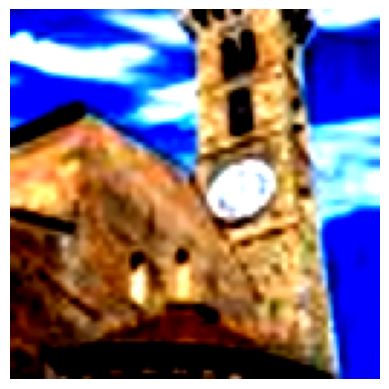

In [36]:
plt.imshow(torch.permute(img, (1, 2, 0)))  # Перестановка каналов для matplotlib
plt.axis('off')

In [47]:
with torch.inference_mode():
    outputs = model(img.unsqueeze(0).to(DEVICE))  # Предсказание от модели
    _, pred_class = torch.max(outputs, 1)  # Выбор класса с максимальной вероятностью
    pred_class = pred_class.item()
print(pred_class)


2


In [44]:
# Получаем классы из датасета
idx2class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}


In [48]:
print(idx2class[pred_class])


bell_tower


8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [ ]:
# code

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями.

In [ ]:
# code

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже.

In [49]:
# code
!git clone git@github.com:olgai05/ds-phase-2.git

Cloning into 'ds-phase-2'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [64]:
!git clone https://github.com/olgai05/ds-phase-2.git

Cloning into 'ds-phase-2'...
fatal: could not read Username for 'https://github.com': No such device or address


In [63]:
!git clone https://github.com/olgai05/ds-phase-2.git


Cloning into 'ds-phase-2'...
fatal: could not read Username for 'https://github.com': No such device or address


In [65]:
!git clone https://github.com/olgai05/level2_project_myResNet.git

Cloning into 'level2_project_myResNet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [67]:
!ls

08-03-demo.ipynb	   archive.zip		       image.jpg		  train
08_03_demo_OL.ipynb	   aux			       imagenet_class_index.json  weights.pt
08-04-demo.ipynb	   cats_and_dogs_filtered      level2_project_myResNet
08_04_demo_variant2.ipynb  cats_and_dogs_filtered.zip  OL_08_03_task_ol.ipynb
08-04-task.ipynb	   image2.jpg		       test


In [68]:
%cd level2_project_myResNet


/content/drive/MyDrive/Elbrus_Moon_phase2_okt_2024/week8/level2_project_myResNet


In [ ]:
!git add .

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта.

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github